In [26]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [69]:
import os, sys

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))


import constants
import toe_constants as toe_const
import time_of_emergence_calc as toe
import utils

logger = utils.get_notebook_logger()

In [160]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=20)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 496.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34227,Workers: 20
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 496.00 GiB
Comm: tcp://127.0.0.1:43119,Total threads: 1
Dashboard: /proxy/35791/status,Memory: 24.80 GiB
Nanny: tcp://127.0.0.1:44045,


In [14]:
xr.DataTree

xarray.core.datatree.DataTree

In [20]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.MODERN_PERIOD
# base_period, base_period.start, base_period.end
base_period_string = str(base_period.value).replace(', ', '_')
base_period_string, base_period

('(1959_1989)', <YearRange.MODERN_PERIOD: (1959, 1989)>)

In [22]:
# Get just the files that have the string 
files = os.listdir(constants.TOE_SAVE_DIR)
files = [f for f in files if base_period_string in f]
files

['best_temperature_(1959_1989)',
 'era5_t2m_(1959_1989)',
 'gpcc_precip_(1959_1989)',
 'access_pr_(1959_1989)']

In [23]:
os.listdir(os.path.join(constants.TOE_SAVE_DIR, files[0]))

['data.zarr', 'toe_metrics.zarr', 'signal.zarr']

In [38]:
toe_metrics_ds = xr.open_dataset(os.path.join(constants.TOE_SAVE_DIR, files[0], 'toe_metrics.zarr'), engine='zarr')

In [129]:
toe_metrics_ds2 = xr.open_dataset(os.path.join(constants.TOE_SAVE_DIR, files[1], 'toe_metrics.zarr'), engine='zarr')

In [132]:
toe_metrics_ds3 = xr.open_dataset(os.path.join(constants.TOE_SAVE_DIR, files[-1], 'toe_metrics.zarr'), engine='zarr',
                                 use_cftime=True)

In [133]:
toe_metrics_ds2

<xarray.Dataset> Size: 3GB
Dimensions:          (time: 46, lat: 721, lon: 1440)
Coordinates:
  * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time             (time) datetime64[ns] 368B 1969-12-31 ... 2014-12-31
Data variables:
    frac             (time, lat, lon) float64 382MB ...
    hd               (time, lat, lon) float64 382MB ...
    ks               (time, lat, lon) float64 382MB ...
    perkins          (time, lat, lon) float64 382MB ...
    sn_hawkins_base  (lat, lon, time) float64 382MB ...
    sn_hawkins_full  (lat, lon, time) float64 382MB ...
    sn_lowess_base   (lat, lon, time) float64 382MB ...
    sn_lowess_full   (lat, lon, time) float64 382MB ...
Attributes:
    long_name:  Kolmogorov-Smirnov

In [39]:
toe_metrics_ds

<xarray.Dataset> Size: 191MB
Dimensions:          (time: 46, lat: 180, lon: 360)
Coordinates:
  * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) datetime64[ns] 368B 1969-12-31 ... 2014-12-31
Data variables:
    frac             (time, lat, lon) float64 24MB ...
    hd               (time, lat, lon) float64 24MB ...
    ks               (time, lat, lon) float64 24MB ...
    perkins          (time, lat, lon) float64 24MB ...
    sn_hawkins_base  (lat, lon, time) float64 24MB ...
    sn_hawkins_full  (lat, lon, time) float64 24MB ...
    sn_lowess_base   (lat, lon, time) float64 24MB ...
    sn_lowess_full   (lat, lon, time) float64 24MB ...
Attributes:
    long_name:  Kolmogorov-Smirnov

In [57]:
def get_test_threshold(test: str) -> float:
    if test in toe_const.PVALUE_TESTS:
        return toe_const.PVALUE_THESHOLD1
    elif test in toe_const.OVERLAP_TESTS:
        return toe_const.OVERLAP_THRESHOLD
    elif 'sn' in test:
        return toe_const.SN_THRESHOLD1
    else:
        # Raise an error for unknown tests
        raise ValueError(f"Unknown test '{test}'. Please check the test name or add it"
                         "to the appropriate category.")

# Test that this function works for all tests
for test in list(toe_metrics_ds): threshold = get_test_threshold(test); print(test, threshold)

frac 62
hd 62
ks 0.01
perkins 62
sn_hawkins_base 1
sn_hawkins_full 1
sn_lowess_base 1
sn_lowess_full 1


In [81]:
def get_non_emergence_mutli_metrics(toe_metrics_ds, logginglevel='ERROR'):
    """
    Determine the locations where specific tests do not emerge based on given thresholds.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
        Each variable in the dataset represents a test, and the final time 
        step (time=-1) is used for comparison against the test's threshold.
    
    logginglevel : str, optional
        The logging level to use during execution. Default is 'ERROR'.
        Possible values: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'CRITICAL'.

    Returns:
    -------
    xarray.Dataset
        A merged dataset where each variable indicates the non-emergence
        condition for the corresponding test in `toe_metrics_ds`. The variables
        are named based on their corresponding test names.

    Notes:
    -----
    - For signal-to-noise ratio (SNR)-related tests (e.g., test names containing "sn"), 
      the non-emergence condition is defined as `np.abs(value) <= threshold`.
    - For all other tests, the non-emergence condition is defined as `value >= threshold`.
    """

    # Adjust the logging level as per the specified parameter
    utils.change_logginglevel(logginglevel)
    
    to_concat = []  # List to store DataArrays for each test's non-emergence condition

    for test in list(toe_metrics_ds):
        # Retrieve the threshold for the current test
        threshold = get_test_threshold(test)
        logger.info(f'{test} - {threshold}')  # Log the test name and its threshold

        # Determine the appropriate comparison function based on the tst type
        # Use np.less_equal for "sn" tests and np.greater_equal for others
        comp_func = np.less_equal if 'sn' in test else np.greater_equal

        # Apply the comparison function to determine non-emergence locations
        # For "sn" tests: np.abs(value) <= threshold
        # For others: value >= threshold
        does_not_emerge_da = comp_func(np.abs(toe_metrics_ds[test].isel(time=-1)), threshold)

        # Append the resulting DataArray to the list for later merging
        to_concat.append(does_not_emerge_da)

    # Merge all individual non-emergence DataArrays into a single Dataset
    does_not_emerge_ds = xr.merge(to_concat)

    return does_not_emerge_ds

In [105]:
def get_permanent_exceedance_multi_metrics(toe_metrics_ds, logginglevel='ERROR'):
    """
    Determine the year of permanent exceedance for multiple tests in the dataset.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
    
    simulation_max : float
        The maximum simulation year. If a test exceeds this year, it is considered not emerged.

    Returns:
    -------
    xarray.Dataset
        A merged dataset containing the year of permanent exceedance for all tests.
    """
    utils.change_logginglevel(logginglevel)
        
    exceedance_list = []

    for test in toe_metrics_ds:
        # Retrieve the threshold dynamically
        threshold = get_test_threshold(test)

        # Determine the comparison function
        comp_func = np.greater_equal if (('sn' in test) or ('hd' in test)) else np.less
        logger.info(f'{test=} - {threshold=} - {comp_func}')

        # Apply absolute value for 'sn'-related tests
        data = np.abs(toe_metrics_ds[test]) if 'sn' in test else toe_metrics_ds[test]

        # Calculate permanent exceedance
        exceedance_da = toe.get_permanent_exceedance(data, threshold=threshold, comparison_func=comp_func)

        exceedance_list.append(exceedance_da)

    # Merge all exceedance results
    toe_ds = xr.merge(exceedance_list)

    # Apply the simulation max threshold
    # toe_ds = xr.where(toe_ds < simulation_max, toe_ds, np.nan)
    return toe_ds


In [82]:
does_not_emerge_ds = get_non_emergence_mutli_metrics(toe_metrics_ds)

In [134]:
toe_ds = get_permanent_exceedance_multi_metrics(toe_metrics_ds, 'ERROR')

In [138]:
does_not_emerge_ds2 = get_non_emergence_mutli_metrics(toe_metrics_ds2, 'INFO')
toe_ds2 = get_permanent_exceedance_multi_metrics(toe_metrics_ds2, 'INFO')

INFO:root:frac - 62
INFO:root:hd - 62
INFO:root:ks - 0.01
INFO:root:perkins - 62
INFO:root:sn_hawkins_base - 1
INFO:root:sn_hawkins_full - 1
INFO:root:sn_lowess_base - 1
INFO:root:sn_lowess_full - 1
INFO:root:test='frac' - threshold=62 - <ufunc 'less'>
INFO:root:test='hd' - threshold=62 - <ufunc 'greater_equal'>
INFO:root:test='ks' - threshold=0.01 - <ufunc 'less'>
INFO:root:test='perkins' - threshold=62 - <ufunc 'less'>
INFO:root:test='sn_hawkins_base' - threshold=1 - <ufunc 'greater_equal'>
INFO:root:test='sn_hawkins_full' - threshold=1 - <ufunc 'greater_equal'>
INFO:root:test='sn_lowess_base' - threshold=1 - <ufunc 'greater_equal'>
INFO:root:test='sn_lowess_full' - threshold=1 - <ufunc 'greater_equal'>


In [139]:
does_not_emerge_ds3 = get_non_emergence_mutli_metrics(toe_metrics_ds3, 'INFO')
toe_ds3 = get_permanent_exceedance_multi_metrics(toe_metrics_ds3, 'INFO')

INFO:root:frac - 62
INFO:root:hd - 62
INFO:root:ks - 0.01
INFO:root:perkins - 62
INFO:root:sn_hawkins_base - 1
INFO:root:sn_hawkins_full - 1
INFO:root:sn_lowess_base - 1
INFO:root:sn_lowess_full - 1
INFO:root:test='frac' - threshold=62 - <ufunc 'less'>
INFO:root:test='hd' - threshold=62 - <ufunc 'greater_equal'>
INFO:root:test='ks' - threshold=0.01 - <ufunc 'less'>
INFO:root:test='perkins' - threshold=62 - <ufunc 'less'>
INFO:root:test='sn_hawkins_base' - threshold=1 - <ufunc 'greater_equal'>
INFO:root:test='sn_hawkins_full' - threshold=1 - <ufunc 'greater_equal'>
INFO:root:test='sn_lowess_base' - threshold=1 - <ufunc 'greater_equal'>
INFO:root:test='sn_lowess_full' - threshold=1 - <ufunc 'greater_equal'>


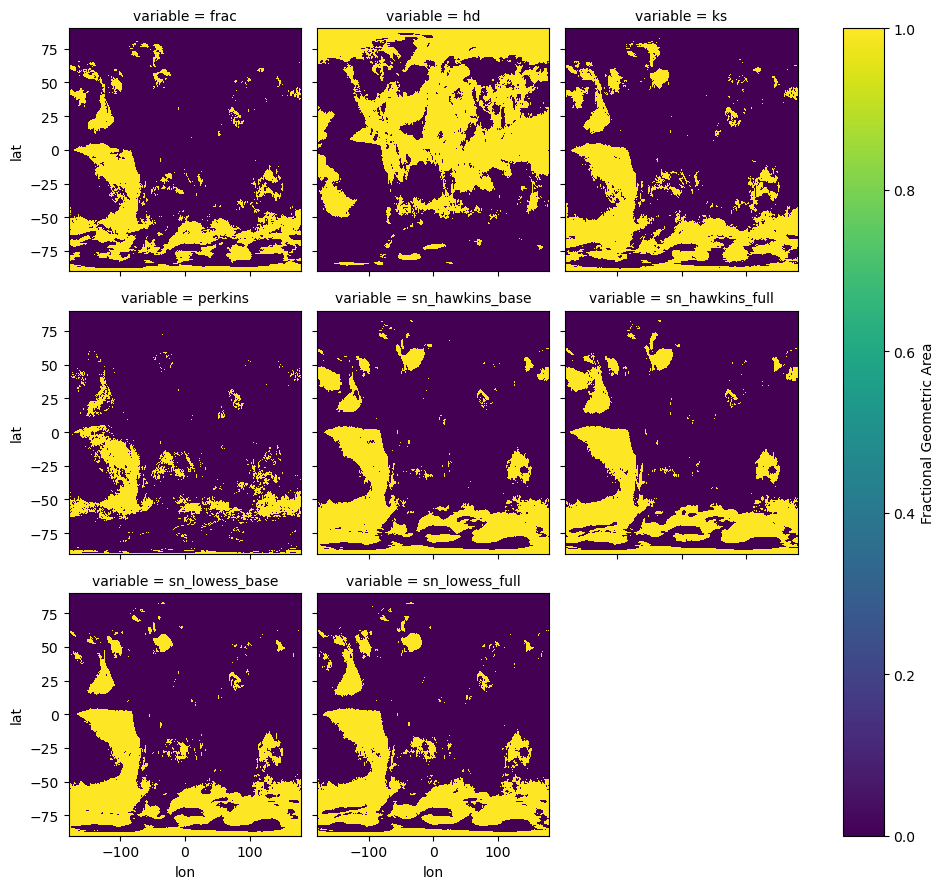

In [140]:
does_not_emerge_ds2.to_array().plot(col='variable', col_wrap=3)

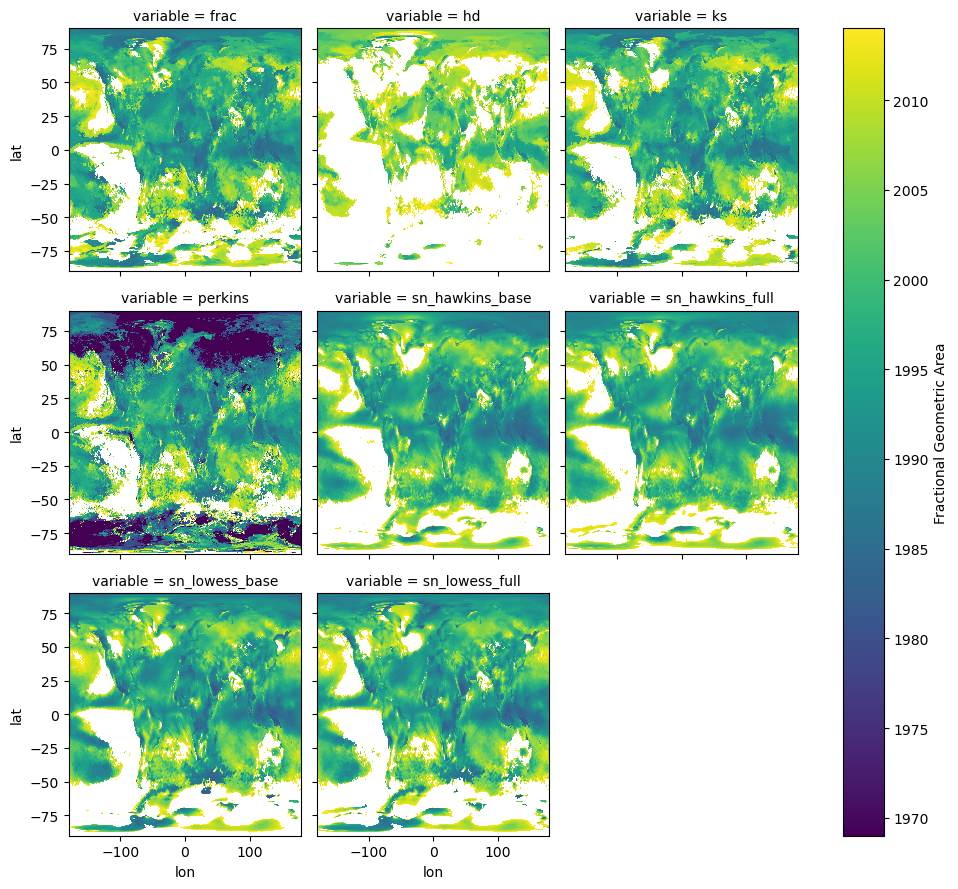

In [141]:
toe_ds2.to_array().plot(col='variable', col_wrap=3)

<h1 style='color:cyan'> Plots</h1>

In [142]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

In [143]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [144]:
list(does_not_emerge_ds)

['frac',
 'hd',
 'ks',
 'perkins',
 'sn_hawkins_base',
 'sn_hawkins_full',
 'sn_lowess_base',
 'sn_lowess_full']

In [145]:
toe_emergence_levels = np.arange(toe_metrics_ds.time.dt.year.values[0],
                                 toe_metrics_ds.time.dt.year.values[-1], 5)

In [157]:
def plot_toe_maps(toe_ds, does_not_emerge_ds, tests_subset_used=None, axes=None, gs=None):
    toe_emergence_levels = np.arange(toe_metrics_ds.time.dt.year.values[0],
                                 toe_metrics_ds.time.dt.year.values[-1], 5)

    if tests_subset_used == None: tests_subset_used = list(toe_ds)
    
    if axes is None:
        fig = plt.figure(figsize=(8, 4*len(tests_subset_used)))
        projection=ccrs.PlateCarree()
    
        gs = gridspec.GridSpec(len(tests_subset_used), 2, width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)
        axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(tests_subset_used))]
    
    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)

    
    for ax, test in zip(axes, tests_subset_used):
    
        does_not_emerge_ds2[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds2[test].plot(ax=ax, **toe_plot_kwargs)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test)
        ax.set_title(title, fontsize=15)
        ax.coastlines()
    
    cbar_axes1 = plt.subplot(gs[:, 0])
    cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')
    cbar1.ax.set_title('Year of Emergence', fontsize=16)
    
    # Add a legend for both the hatching and "Does Not Emerge"
    legend_elements = [
        plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
        plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
    ]
    legend_labels = ['Not Enough Data', 'Does Not Emerge']
    legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                               bbox_to_anchor=(6, 1.09), fontsize=10, ncol=2)

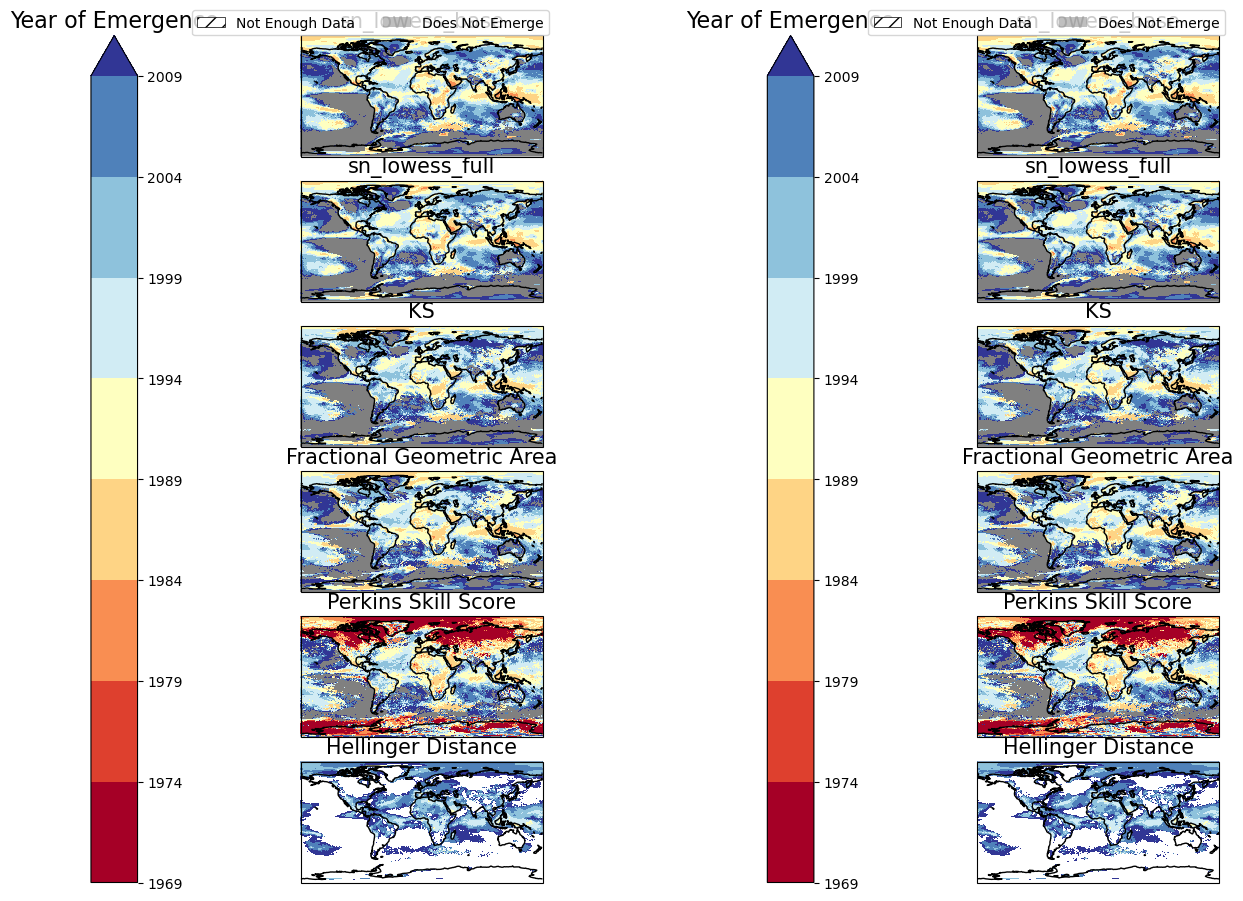

In [162]:
fig = plt.figure(figsize=(16, 11))
outer_gs = gridspec.GridSpec(1, 2)

inner_gs1 = gridspec.GridSpecFromSubplotSpec(
    len(tests_subset_used), 2, subplot_spec=outer_gs[0],
    width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)

inner_gs2 = gridspec.GridSpecFromSubplotSpec(
    len(tests_subset_used), 2, subplot_spec=outer_gs[1],
    width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)

axes1 = [fig.add_subplot(inner_gs1[i, 1], projection=projection) for i in range(len(tests_subset_used))]

axes2 = [fig.add_subplot(inner_gs2[i, 1], projection=projection) for i in range(len(tests_subset_used))]

plot_toe_maps(toe_ds, does_not_emerge_ds, tests_subset_used, axes1, inner_gs1)
plot_toe_maps(toe_ds2, does_not_emerge_ds2, tests_subset_used, axes2, inner_gs2)


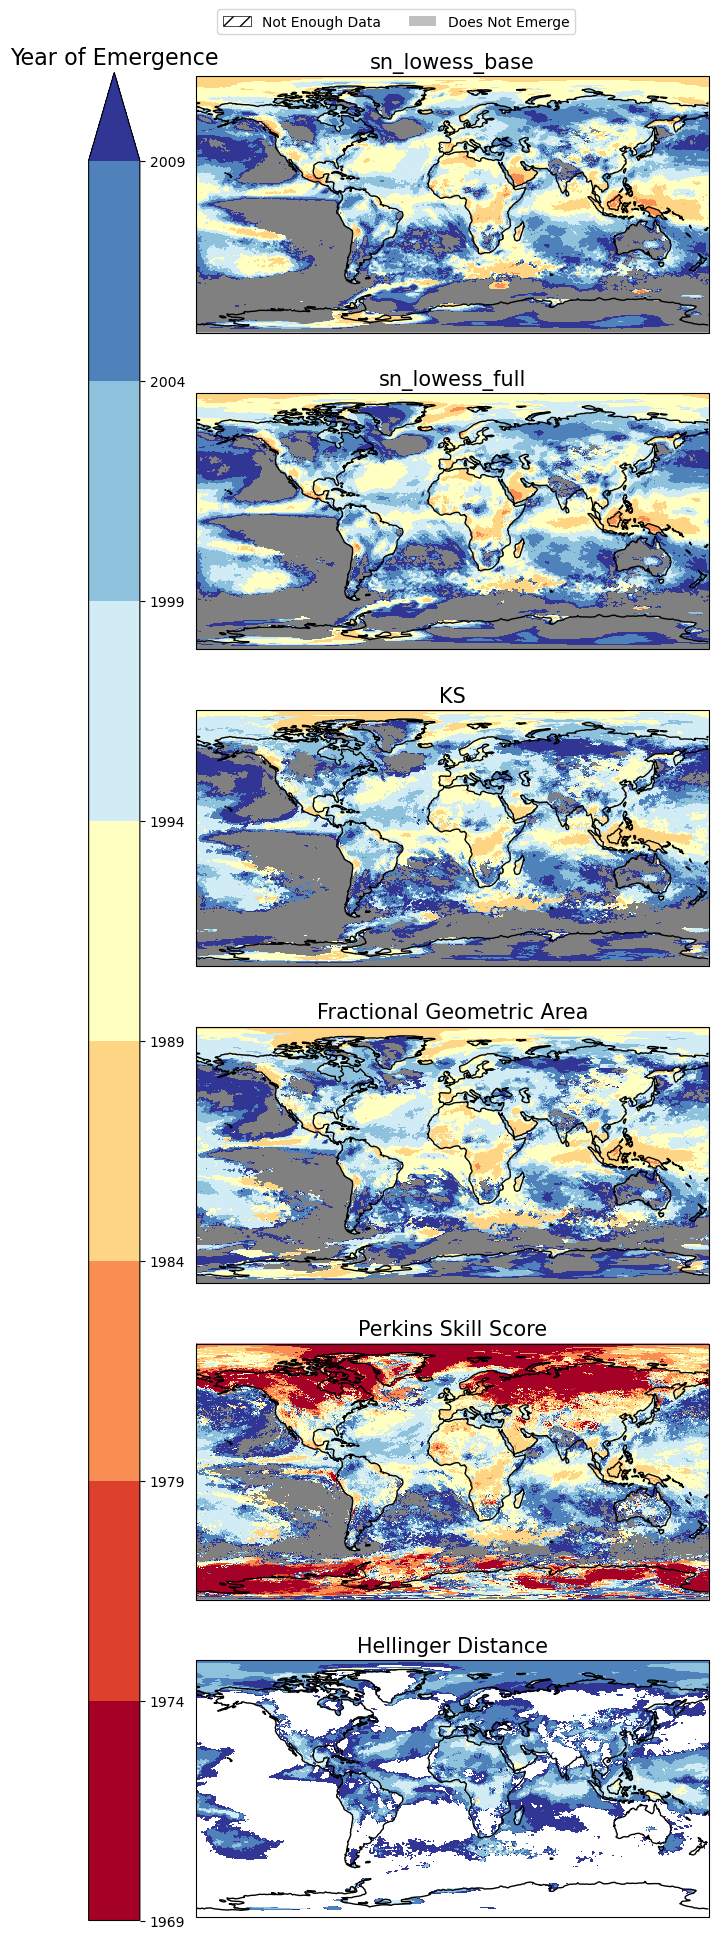

In [147]:
tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac', 'perkins', 'hd']

fig = plt.figure(figsize=(8, 4*len(tests_subset_used)))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(len(tests_subset_used), 2, width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)
axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(tests_subset_used))]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)


for ax, test in zip(axes, tests_subset_used):

    does_not_emerge_ds2[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds2[test].plot(ax=ax, **toe_plot_kwargs)
    title =  toe_const.NAME_CONVERSION_DICT.get(test, test)
    ax.set_title(title, fontsize=15)
    ax.coastlines()

cbar_axes1 = plt.subplot(gs[:, 0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(6, 1.09), fontsize=10, ncol=2)